# Inference


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import onnxruntime as ort
import cv2

In [6]:
onnx_model_path = "onnx_exports/unet_fetus_segmentation.onnx"

In [7]:
ort_session = ort.InferenceSession(onnx_model_path)

In [11]:
test_img_path = r"preprocessed_images/0.png"

In [8]:
TARGET_WIDTH = 600
TARGET_HEIGHT = 400

In [26]:
img = Image.open(test_img_path).convert('L')
resized_img = img.resize((TARGET_WIDTH, TARGET_HEIGHT), Image.LANCZOS)
img_array = np.array(resized_img, dtype=np.float32) / 255.0

In [13]:
input_tensor = img_array[np.newaxis, np.newaxis, :, :]

In [44]:

# Run inference
ort_inputs = {ort_session.get_inputs()[0].name: input_tensor}
ort_outputs = ort_session.run(None, ort_inputs)
# Convert outputs to tensors
ort_preds = ort_outputs[0]
sigmoid_preds = 1 / (1 + np.exp(-ort_preds))
predicted_mask = sigmoid_preds[0, 0]
# Binarize predictions using threshold 0.5
predicted_mask_bin = (predicted_mask > 0.5).astype(np.uint8)

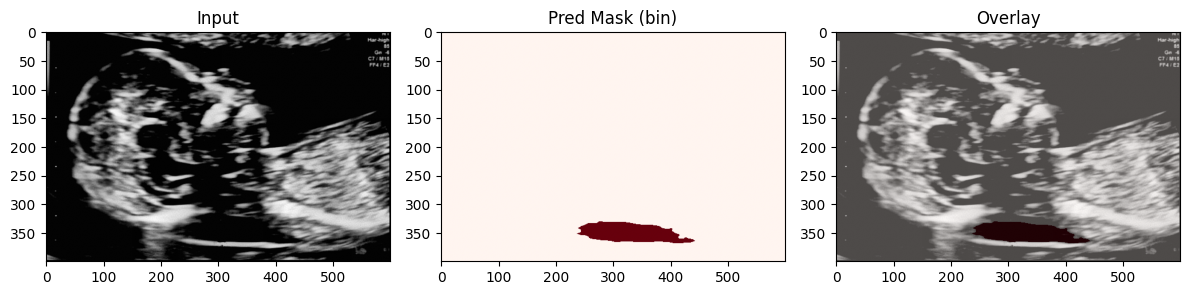

In [45]:
# Visualize first sample
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img_array, cmap='gray'); plt.title("Input")
plt.subplot(1,3,2)
plt.imshow(predicted_mask_bin * 255, cmap='Reds')
plt.title("Pred Mask (bin)")
plt.subplot(1,3,3)
plt.imshow(img_array, cmap='gray')
plt.imshow(predicted_mask_bin * 255, cmap='Reds', alpha=0.3)
plt.title("Overlay")
plt.tight_layout()
plt.show()

In [31]:
contours, _ = cv2.findContours(predicted_mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnt = max(contours, key=cv2.contourArea)
ellipse = cv2.fitEllipse(cnt)
center, axes, angle = ellipse
minor_axis, major_axis = axes
# The Nuchal translucency is meassured as the length of the minor axis
print(f"Nuchal translucency: {minor_axis:.2f} pixels")

Nuchal translucency: 30.39 pixels


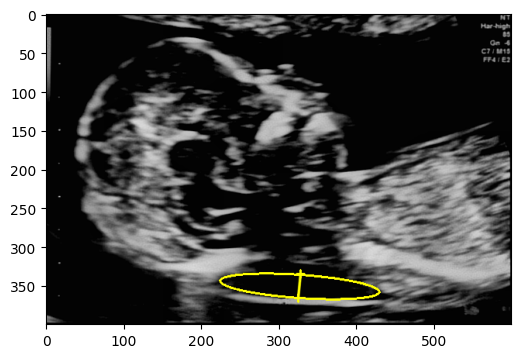

In [39]:
# Get both points of the minor axis, show them as an X, and connect them with a dashed line (all yellow)
x1 = int(center[0] - minor_axis / 2 * np.cos(np.deg2rad(angle)))
y1 = int(center[1] - minor_axis / 2 * np.sin(np.deg2rad(angle)))
x2 = int(center[0] + minor_axis / 2 * np.cos(np.deg2rad(angle)))
y2 = int(center[1] + minor_axis / 2 * np.sin(np.deg2rad(angle)))
# Convert the image to BGR for OpenCV drawing
color_array = cv2.cvtColor((img_array * 255.0).astype(np.uint8), cv2.COLOR_GRAY2BGR)
# Draw the points and the line
cv2.drawMarker(color_array, (x1, y1), color=(0, 255, 255), markerType=cv2.MARKER_CROSS, markerSize=10, thickness=2)
cv2.drawMarker(color_array, (x2, y2), color=(0, 255, 255), markerType=cv2.MARKER_CROSS, markerSize=10, thickness=2)
cv2.line(color_array, (x1, y1), (x2, y2), color=(0, 255, 255), thickness=2, lineType=cv2.LINE_AA)
cv2.ellipse(color_array, (int(center[0]), int(center[1])), (int(minor_axis / 2), int(major_axis / 2)), angle, 0, 360, (0, 255, 255), thickness=2)
# Show the image with the points and line
color_array = cv2.cvtColor(color_array, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(color_array)